## 本章での学び

* ニューラルネットにおける学習とは
  * 重みパラメータの値をデータから自動に決定すること。
  * その手法の1つとして勾配法というものがある。
    * 損失関数の最小値を探す、できるだけ小さな値を探す
    * 本章では損失関数に交差エントロピー誤差を使う。

In [2]:
import sys, os

sys.path.append(os.pardir)
from dataset.mnist import load_mnist
import numpy as np
from PIL import Image
import pickle
from common.functions import sigmoid, softmax


In [3]:
def sum_squared_error(y, t):
    """二乗和誤差

    Args:
        y (_type_): _description_
        t (_type_): _description_

    Returns:
        _type_: _description_
    """
    return 0.5 * np.sum((y - t) ** 2)


In [4]:
# 2を正解とするラベルを作成
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
# ニューラルネットワークの出力を仮で作成。2の確率が最も高くなるように。
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
sum_squared_error(np.array(y), np.array(t))


0.09750000000000003

In [5]:
# ニューラルネットワークの出力を仮で作成。7の確率が最も高くなるように。
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
sum_squared_error(np.array(y), np.array(t))


0.5975

In [6]:
def cross_entropy_error(y, t):
    """交差エントロピー誤差

    Args:
        y (_type_): ニューラルネットワークの出力
        t (_type_): 正解ラベル(正解1、その他0を取るラベル)

    Returns:
        _type_: 正解ラベルに近いほど0に近づく値
    """
    if y.ndim == 1:
        # データが1次元の場合
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    # 微小な値を足している。log(0)だとマイナス無限になるので、それの対策
    delta = 1e-7
    # データ1つあたりの平均交差エントロピー誤差を計算
    return -np.sum(t * np.log(y + delta)) / batch_size


In [7]:
# 2を正解とするラベルを作成
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
# ニューラルネットワークの出力を仮で作成。2の確率が最も高くなるように。
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))


0.510825457099338

In [8]:
# ニューラルネットワークの出力を仮で作成。7の確率が最も高くなるように。
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))


2.302584092994546

In [9]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
print(x_train.shape)
print(t_train.shape)


(60000, 784)
(60000, 10)


In [10]:
train_size = x_train.shape[0]
batch_size = 10
# 60000個のデータから10個ランダムに抽出
# batch_sizeにはミニバッチに使用するデータのインデックスが格納されている
# 例 np.random.choice(10, 3)-> [0, 3, 4]
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]


In [11]:
def numerical_diff(f, x):
    """中心差分による数値微分

    Args:
        f (_type_): function
        x (_type_): _description_

    Returns:
        _type_: _description_
    """
    h = 1e-4
    return (f(x + h) - f(x - h)) / (2 * h)


In [12]:
def function_1(x):
    return 0.01 * x**2 + 0.1 * x


def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d * x
    return lambda t: d * t + y


0.1999999999990898


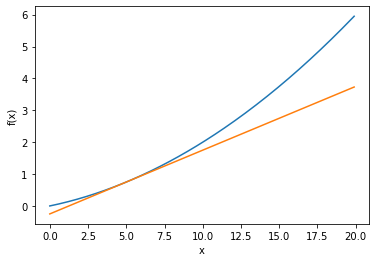

In [13]:
from matplotlib import pyplot as plt

x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf = tangent_line(function_1, 5)
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)


In [14]:
numerical_diff(function_1, 5)


0.1999999999990898

In [15]:
numerical_diff(function_1, 10)


0.2999999999986347

Text(0, 0.5, 'X1')

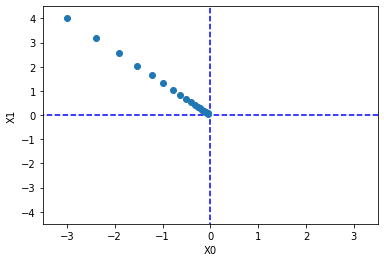

In [16]:
from ch04.gradient_2d import numerical_gradient


def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append(x.copy())

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)


def function_2(x):
    return x[0] ** 2 + x[1] ** 2


init_x = np.array([-3.0, 4.0])

lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot([-5, 5], [0, 0], "--b")
plt.plot([0, 0], [-5, 5], "--b")
plt.plot(x_history[:, 0], x_history[:, 1], "o")

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")


In [17]:
from common.gradient import numerical_gradient
from common.functions import cross_entropy_error

# 練習用の簡単なニューラルネットワーク
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2, 3)

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        """損失関数

        Args:
            x (_type_): 入力データ
            t (_type_): 正解ラベル

        Returns:
            _type_: _description_
        """
        # 予測した結果をzに格納
        z = self.predict(x)
        # 出力層の活性化関数としてソフトマックス関数を使う
        y = softmax(z)
        # ニューラルネットワークの出力とラベルを使って損失を計算
        # yが正解tに近いほど0に近い値が得られる。
        loss = cross_entropy_error(y, t)

        return loss


In [18]:
net = simpleNet()
print(net.W)


[[ 0.12971962  0.94227663 -0.79217114]
 [-1.12773576 -0.05372376  0.87135132]]


In [19]:
x = np.array([0.6, 0.9])
# 予測
p = net.predict(x)
print(p)
np.argmax(p)


[-0.93713041  0.5170146   0.30891351]


1

In [20]:
t = np.array([0, 0, 1])
net.loss(x, t)


0.9238530586994503

In [21]:
def f(W):
    return net.loss(x, t)


# 上記f(w)は以下のよラムダ記法を使えるので、以降はラムダ記法を使う
# f = lambda W:net.loss(x,t)
dW = numerical_gradient(f, net.W)
print(dW)


[[ 0.06851359  0.29329449 -0.36180808]
 [ 0.10277039  0.43994173 -0.54271212]]


In [22]:
from common.functions import *


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_sizes, weight_init_sdt=0.01):
        # 重みの初期化
        # 重みはガウス分布に従う乱数で初期化。バイアスは0で初期化
        self.params = {}
        self.params["W1"] = weight_init_sdt * np.random.randn(input_size, hidden_size)
        self.params["b1"] = np.zeros(hidden_size)
        self.params["W2"] = weight_init_sdt * np.random.randn(hidden_size, output_sizes)
        self.params["b2"] = np.zeros(output_sizes)

    def predict(self, x):
        W1, W2 = self.params["W1"], self.params["W2"]
        b1, b2 = self.params["b1"], self.params["b2"]
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        return y

    def loss(self, x, t):
        """ロス関数

        Args:
            x (_type_): 入力データ
            t (_type_): 正解ラベルデータ（one-hot)

        Returns:
            _type_: 損失値
        """

        y = self.predict(x)
        return cross_entropy_error(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        # 処理に時間がかかる。現在の環境だとトータル2分ぐらい。
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        # common.gradient.pyが呼び出される。
        # 以下4回、勾配を求める処理を行う。1回目は数が多いので特に時間がかかる。
        grads["W1"] = numerical_gradient(loss_W, self.params["W1"])
        grads["b1"] = numerical_gradient(loss_W, self.params["b1"])
        grads["W2"] = numerical_gradient(loss_W, self.params["W2"])
        grads["b2"] = numerical_gradient(loss_W, self.params["b2"])
        return grads


In [23]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_sizes=10)
net.params["W1"].shape


(784, 100)

In [24]:
# 推論の実行
x = np.random.rand(100, 784)
y = net.predict(x)


In [25]:
# 勾配情報の確認
t = np.random.rand(100, 10)
grads = net.numerical_gradient(x, y)
grads["W1"].shape


(784, 100)

train acc, test acc |0.10441666666666667,0.1028
train acc, test acc |0.7794666666666666,0.7842
train acc, test acc |0.8781333333333333,0.8821
train acc, test acc |0.8980833333333333,0.9022
train acc, test acc |0.9083166666666667,0.9122
train acc, test acc |0.9144,0.9158
train acc, test acc |0.9196333333333333,0.9188
train acc, test acc |0.9227166666666666,0.924
train acc, test acc |0.92535,0.9269
train acc, test acc |0.9307,0.9311
train acc, test acc |0.9330166666666667,0.9329
train acc, test acc |0.9359333333333333,0.9354
train acc, test acc |0.938,0.9383
train acc, test acc |0.9404,0.9385
train acc, test acc |0.9432,0.94
train acc, test acc |0.9443666666666667,0.9421
train acc, test acc |0.9458,0.9431


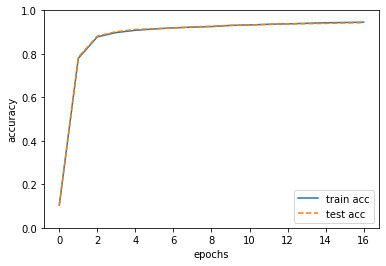

In [4]:
import sys, os

sys.path.append(os.pardir)
from dataset.mnist import load_mnist
import numpy as np
from PIL import Image
import pickle
from common.functions import sigmoid, softmax
from ch04.two_layer_net import TwoLayerNet
from matplotlib import pyplot as plt

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
# x_train size = (60000, 784)
# print(f"x_train size = {x_train.shape}")
train_loss_list = []
train_acc_list = []
test_acc_list = []

# ハイパーパラメータ
iters_num = 10000
batch_size = 100
learning_rate = 0.1
train_size = x_train.shape[0]
# 1エポックあたりの繰り返し数
# デフォルト=60000/100 = 600
iter_per_epoch = max(train_size / batch_size, 1)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # ミニバッチ処理
    # 訓練データの中からランダムに100個のデータを取り出す
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    ### 勾配法
    # 勾配の計算
    # grad = network.numerical_gradient(x_batch,t_batch)
    grad = network.gradient(x_batch, t_batch)  # 高速版

    # 勾配を使ってパラメータの更新
    for key in ("W1", "b1", "W2", "b2"):
        network.params[key] -= learning_rate * grad[key]
    ###

    # 学習経過の記録
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1エポック毎に認識精度を計算
    if i % iter_per_epoch == 0:
        # 学習データは6万枚。これを1万回学習する。
        # 学習は100枚単位のバッチに分けて行い、1エポック=600枚学習が終了したごとにこの処理を実施。
        # ミニバッチ処理を6回実施ごとにこの処理を行う。

        # 現時点での訓練データに対する予測精度を計算
        train_acc = network.accuracy(x_train, t_train)
        # 現時点での評価データに対する予測精度を計算
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc |" + str(train_acc) + "," + str(test_acc))


markers = {"train": "o", "test": "s"}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label="train acc")
plt.plot(x, test_acc_list, label="test acc", linestyle="--")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc="lower right")
